In [1]:
%matplotlib inline
import scipy.io, os, math, matplotlib.pyplot as plt, random, numpy as np, pandas, pdb,  itertools, glob, codecs
import graph_tool as gt
import re
import matplotlib

Reproduce part of the basic finding of Youn et al. 2016. Their Figure 2 shows a semantic network, such that each node is a concept and the weight on each link between two nodes represents the prevalence of polysemy linking these two concepts.  We will construct a network similar to this one (but smaller) using IDS data. Because we are using a different dataset, there may be some discrepancies from their results.

For the purpose of this replication, focus on the concept WIND (IDS concept code 1-720),  which is a minor hub in the Youn et al. graph.  Use IDS data to construct the neighborhood of WIND, and compare results with those of Youn et al.  Specifically: for each wordlist in the IDS, note which concepts (if any) in that wordlist receive the same label as the concept WIND.  For each such "neighboring" concept, keep track of the number of IDS wordlists that use the same word for that neighbor and for WIND: that will be the weight on the link connecting WIND to the neighbor node.

Print out results as follows:
1. Print out the number of concepts that are neighbors of WIND.
2. Many of these will have very weak links, e.g. just one wordlist contributing. For each neighbor concept that is connected to WIND by 2 or more languages, print out the concept and the number of wordlists that contribute to the link, i.e. the weight of the link.

# Replication

Focus on WIND, which is a minor hub in the youn et al. graph.  Use IDS data to construct its neighborhood, and compare results with those of youn et al.  Specifically: for each wordlist in IDS, note which concepts (if any) receive the same label as the concept WIND. For each such "neighboring" concept, keep track of the number of IDS lgs that use same word for neighbor and for WIND.  Then print out results.

In [2]:
# read in data that associates climate with languages.  NB: this is 
# organized by language, and indexed by glottocode for the language.
ids_data_from_matlab = scipy.io.loadmat('../4/ridsplusdata.mat')
# mean temp is in col number 5, and is temperature * 10, hence /10 here.
ids_temps = ids_data_from_matlab['rorigclimdata'][:,5]/10.
# list of glottocodes, in same order as temp.
ids_gcs = [x[0][0] for x in ids_data_from_matlab['rlabels']]
temp_for_glottocode = dict(zip(ids_gcs, ids_temps))

/home/stephan/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [3]:
gc_by_lg = {}
with open('../4/allcodes.txt') as f:
    for line in f:
        elts = line.split(' ')
        idsnum = int(elts[0])
        gc = elts[1]
        iso = elts[2]
        gc_by_lg[idsnum] = gc 
        

In [4]:
# read in each IDS word list file, and stash away contents for later
# munging. 
# NB: these data are in the form of wordlists, sometimes more than one
# per language.
# NB: all keys in each wl are concept codes EXCEPT for: 'num', 'lgname'.
filename_template = '../4/ids/*.txt'
wls = []  # word lists
concept_name = {}  # store name of each concept, indexed by code.
lg_name = {}  # store name of each language, indexed by code.
for fname in glob.glob(filename_template):  
    # print fname
    wl = {}  # dict for this word list
    with codecs.open(fname, encoding='utf-8') as f:
        for line in f:
            elts = line.split('\t')
            fullcode = elts[0]
            # weed out header row
            if (fullcode != 'ID'):
                # concept code is 1st 2 elts of full code.
                code_chunks = fullcode.split('-')[:2]
                code = "-".join(code_chunks)
                form = elts[1]
                concept = elts[2]
                concept_name[code] = concept
                lgname = elts[3].strip()
                # one list for each IDS meaning code
                if (code not in wl.keys()):
                    wl[code] = [ form ]
                else:
                    wl[code].append(form)
        #print os.path.splitext(os.path.basename(fname))[0]
        num = int(os.path.splitext(os.path.basename(fname))[0])  # chop off ".txt" and int-ify
        wl['num'] = num
        wl['lgname'] = lgname
        #lg_name[num] = lgname
        wls.append(wl)

In [ ]:
#index in by concept code, e.g. wind
#find all other links that are linked by the form
#get all other concepts that are linked; add to them if necessary


In [148]:
def getDFforConcept(targetConcept):
    results = []
    wl_index = 0
    for wl in wls:
        # cycle through wordlists.
        # entry for ice or snow
        rdict = {}
        rdict['index'] = wl_index
        wl_index += 1
        rdict['language'] = wl['lgname']
        rdict['glottocode'] = gc_by_lg[wl['num']]
        if not rdict['glottocode'] or rdict['glottocode'] == 'empty123':
            rdict['error'] = 'Missing glottocode' 
        else:      
            rdict['temp'] = temp_for_glottocode[rdict['glottocode']]
            if targetConcept in wl:                                    
                if np.isnan(rdict['temp']):
                    rdict['error'] = 'Missing temperature'
                else:
                    targetForm = wl[targetConcept]
                    colexicalizedForms = []
                    for concept, form in wl.items():
                        if form == targetForm and concept != targetConcept:
                            colexicalizedForms.append(concept)                                
                    rdict['conceptList'] = colexicalizedForms                
            else:
                rdict['error'] = 'concept missing from wordlist'                

            results.append(rdict)  
    return(results)

def getNeighborsForConcept(concept):            
    df = pandas.DataFrame(getDFforConcept(concept))
    neighbor_count = 0 
    neighbors = {}
    for i in df.index:
        rowDict = df.ix[i].to_dict()
        if type(rowDict['conceptList']) is list:
            if len(rowDict['conceptList']) > 0:
                for concept in rowDict['conceptList']:
                    neighbor_count+=1
                    if concept in neighbors:
                        neighbors[concept].append(rowDict['glottocode'])
                    else:    
                        neighbors[concept] = [rowDict['glottocode']]        
    return(neighbors)

In [6]:
neighbors = getNeighborsForConcept('1-720')
neighbors

{u'1-100': [237],
 u'1-210': [237],
 u'1-510': [66, 237],
 u'1-580': [26, 38, 57, 89, 93, 122, 138, 165, 185, 219, 235, 266],
 u'1-710': [6,
  10,
  20,
  59,
  66,
  81,
  84,
  99,
  116,
  120,
  121,
  127,
  139,
  140,
  144,
  176,
  210,
  235,
  236,
  237,
  242,
  248,
  273],
 u'1-780': [6, 66],
 u'10-710': [76],
 u'12-340': [183],
 u'12-470': [183],
 u'14-740': [278],
 u'17-230': [12],
 u'17-320': [46, 213],
 u'22-350': [214],
 u'3-160': [10],
 u'4-510': [99, 121],
 u'9-790': [26, 116],
 u'9-791': [163]}

In [7]:
# examine neighbors
print "Replication"
print "Number of wind neighbors is", len(neighbors)
# print out neighbors, sorted by num of lgs involved in link.
for concept in sorted(neighbors, key=lambda k: len(neighbors[k]), reverse=True):
    num = len(neighbors[concept])
    if num >= 1:
        print concept_name[concept]+' ['+concept+']: '+str(num)

Replication
Number of wind neighbors is 17
air [1-710]: 23
storm [1-580]: 12
sky [1-510]: 2
weather [1-780]: 2
forget [17-320]: 2
fan (noun) [9-790]: 2
breathe, breath [4-510]: 2
bottom [12-340]: 1
road [10-710]: 1
pasture [3-160]: 1
winter [14-740]: 1
earth, land [1-210]: 1
world [1-100]: 1
north [12-470]: 1
demon (evil spirit) [22-350]: 1
insane, crazy [17-230]: 1
fan (vb) [9-791]: 1


In [8]:
# Extension 1: Run on all concepts

In [9]:
# Populate a matrix with all pairwise concept relations

In [10]:
# get a list of concepts ordered by frequency
conceptCount = {}
for wl in wls:
    for key in wl.keys():
        if key in conceptCount:
            conceptCount[key] += 1
        else:    
            conceptCount[key] = 1

conceptCounts = pandas.DataFrame({'concept':conceptCount.keys(), 'numLanguages': conceptCount.values()})   
conceptCounts = conceptCounts[~conceptCounts["concept"].isin(['num','lgname'])]
conceptCounts['label'] = [concept_name[x] for x in conceptCounts['concept']]
topThousand = conceptCounts.sort_values(by='numLanguages', ascending=False).head(1000)
topThousand.index = range(1000)
topThousand

,concept,numLanguages,label
0,4-150,283,blood
1,1-810,283,fire
2,4-140,283,hair (head)
3,4-120,283,"skin, hide"
4,1-310,283,water
5,4-330,283,hand
6,4-160,282,bone
7,1-750,282,rain (noun)
8,4-370,282,foot
9,10-380,282,blow


In [20]:
#get colexicalization counts for top 1000 concepts
conceptCodeToIndex = dict(zip(topThousand['concept'],topThousand.index))

linkM = np.zeros([1000,1000]).astype('uint64')

for target1concept in topThousand['concept']:
    print('Processing '+target1concept+'...')
    if target1concept in conceptCodeToIndex:
        target1conceptIndex = conceptCodeToIndex[target1concept]
        
        neighbors = getNeighborsForConcept(target1concept)    
    
        for target2concept in neighbors:
            if target2concept in conceptCodeToIndex:
                target2conceptIndex = conceptCodeToIndex[target2concept]
                linkM[target1conceptIndex,target2conceptIndex] = len(neighbors[target2concept])    
            else:
                #target2 concept is not in the list of concepts of interest  
                pass
    else:
        # target1 concept is not in the list of concepts of interest
        pass 


Processing 4-150...
Processing 1-810...
Processing 4-140...
Processing 4-120...
Processing 1-310...
Processing 4-330...
Processing 4-160...
Processing 1-750...
Processing 4-370...
Processing 10-380...
Processing 4-260...
Processing 4-270...
Processing 4-200...
Processing 4-610...
Processing 4-230...
Processing 1-520...
Processing 4-210...
Processing 1-840...
Processing 4-220...
Processing 2-210...
Processing 4-360...
Processing 1-540...
Processing 5-110...
Processing 2-220...
Processing 4-310...
Processing 4-750...
Processing 10-450...
Processing 7-120...
Processing 2-270...
Processing 2-360...
Processing 5-130...
Processing 1-510...
Processing 2-350...
Processing 9-360...
Processing 12-560...
Processing 4-440...
Processing 1-730...
Processing 4-580...
Processing 4-240...
Processing 3-610...
Processing 1-360...
Processing 1-440...
Processing 1-830...
Processing 2-320...
Processing 1-851...
Processing 4-460...
Processing 4-760...
Processing 4-300...
Processing 1-410...
Processing 4-280.

In [ ]:
import pickle
pickle.dump( linkM, open( "linkM.pickle", "wb" ) )

In [21]:
sum(linkM)

array([  9,  74,  95, 132,  52, 103,  35,  21,  80,  23,  92,  34,  47,
        21,  39,  68,  24,  14,   4, 108,  15,  26,  29, 143,  92,   7,
        65,  92, 106,  26,  19, 103,  26,  24,  37,  18,  64,  13,  46,
         5,  13,   8,  41,  77,  51,  24,  40,  12,  32,  24,  76,  23,
        36,   8,  53,  36,  20,  15,  18, 152,  35, 109, 155,  29,  36,
       111,  61,  21,  19,  58,  38,  20,  63,  23,  31, 118,  16,   8,
        38,   2,  49,  32,  33,  16,  31,  28,  33,  33,  22,  98,  15,
        43,  84,  52,  38,  43,  94,  12,  91,   7,  13,  74,  19,  52,
        25,  59,  64,  29,  40,  59,  28,  57,  61,  41,   7,  20,  32,
         6,  59,  20,   3,  16,  41,  27, 304,  17,  26,   8,  34, 105,
        42,  59,  25,  25,  30,  97,  47,  37,  15,  38,  57,  16,  14,
         7,  13,  38,  42,  68,  88,  97,  26,   8,  17,  11,  20,  16,
        20,  10,  13,  29,  44,  20,  74, 146,  23,   7,  20,  11,  96,
         8,  20,   9,  21,   2,  29,  12,  21, 155,  25,  74,  5

In [ ]:
# create an appropriate JSON

### Example graph_tool Graph

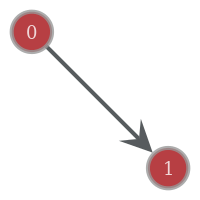

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f377bfe2d90, at 0x7f376ca53f90>

In [22]:
from graph_tool.all import *
g = Graph()
v1 = g.add_vertex()
v2 = g.add_vertex()
e = g.add_edge(v1, v2)

graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=18, output_size=(200, 200), output="two-nodes.png")

In [ ]:
graph_draw(g, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0],
           vertex_fill_color=age, vertex_size=1, edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r, output="price.png")

Each  of 1000 words is a node. Plot connections between the nodes: width of the edge is the number of colexifications. The size of each should vertex node should be the number of times that it appears in the dataset 

In [129]:
g2 = gt.Graph(directed=False)

labels = g2.new_vertex_property("string")
numColex = g2.new_edge_property("float")
colexDistance = g2.new_edge_property("float")
labelList = topThousand['label'].tolist()
vertexMap = {}

for i in range(len(labelList)):    
    for j in range(i):          
        if linkM[i,j] > 10: #prune nodes with too few edges
            if i not in vertexMap:
                v_i = g2.add_vertex()
                labels[v_i.__int__()] = re.sub(',* .*','',labelList[i])
                vertexMap[i] = v_i.__int__()
            else:
                v_i = vertexMap[i]
                
            if j not in vertexMap:
                v_j = g2.add_vertex()
                labels[v_j.__int__()] = re.sub(',* .*','',labelList[j])
                vertexMap[j] = v_j.__int__()
            else:
                v_j = vertexMap[j]
                                
            e = g2.add_edge(v_i,v_j)
            numColex[e] = linkM[i,j] / 10
            colexDistance[e] = 1/linkM[i,j]


            
g2.vertex_properties["labels"] = labels
g2.edge_properties["numColex"] = numColex
g2.edge_properties["colexDistance"] = colexDistance

In [123]:
#confirm the symmetry of the links matrix
(linkM.transpose() == linkM).all()

True

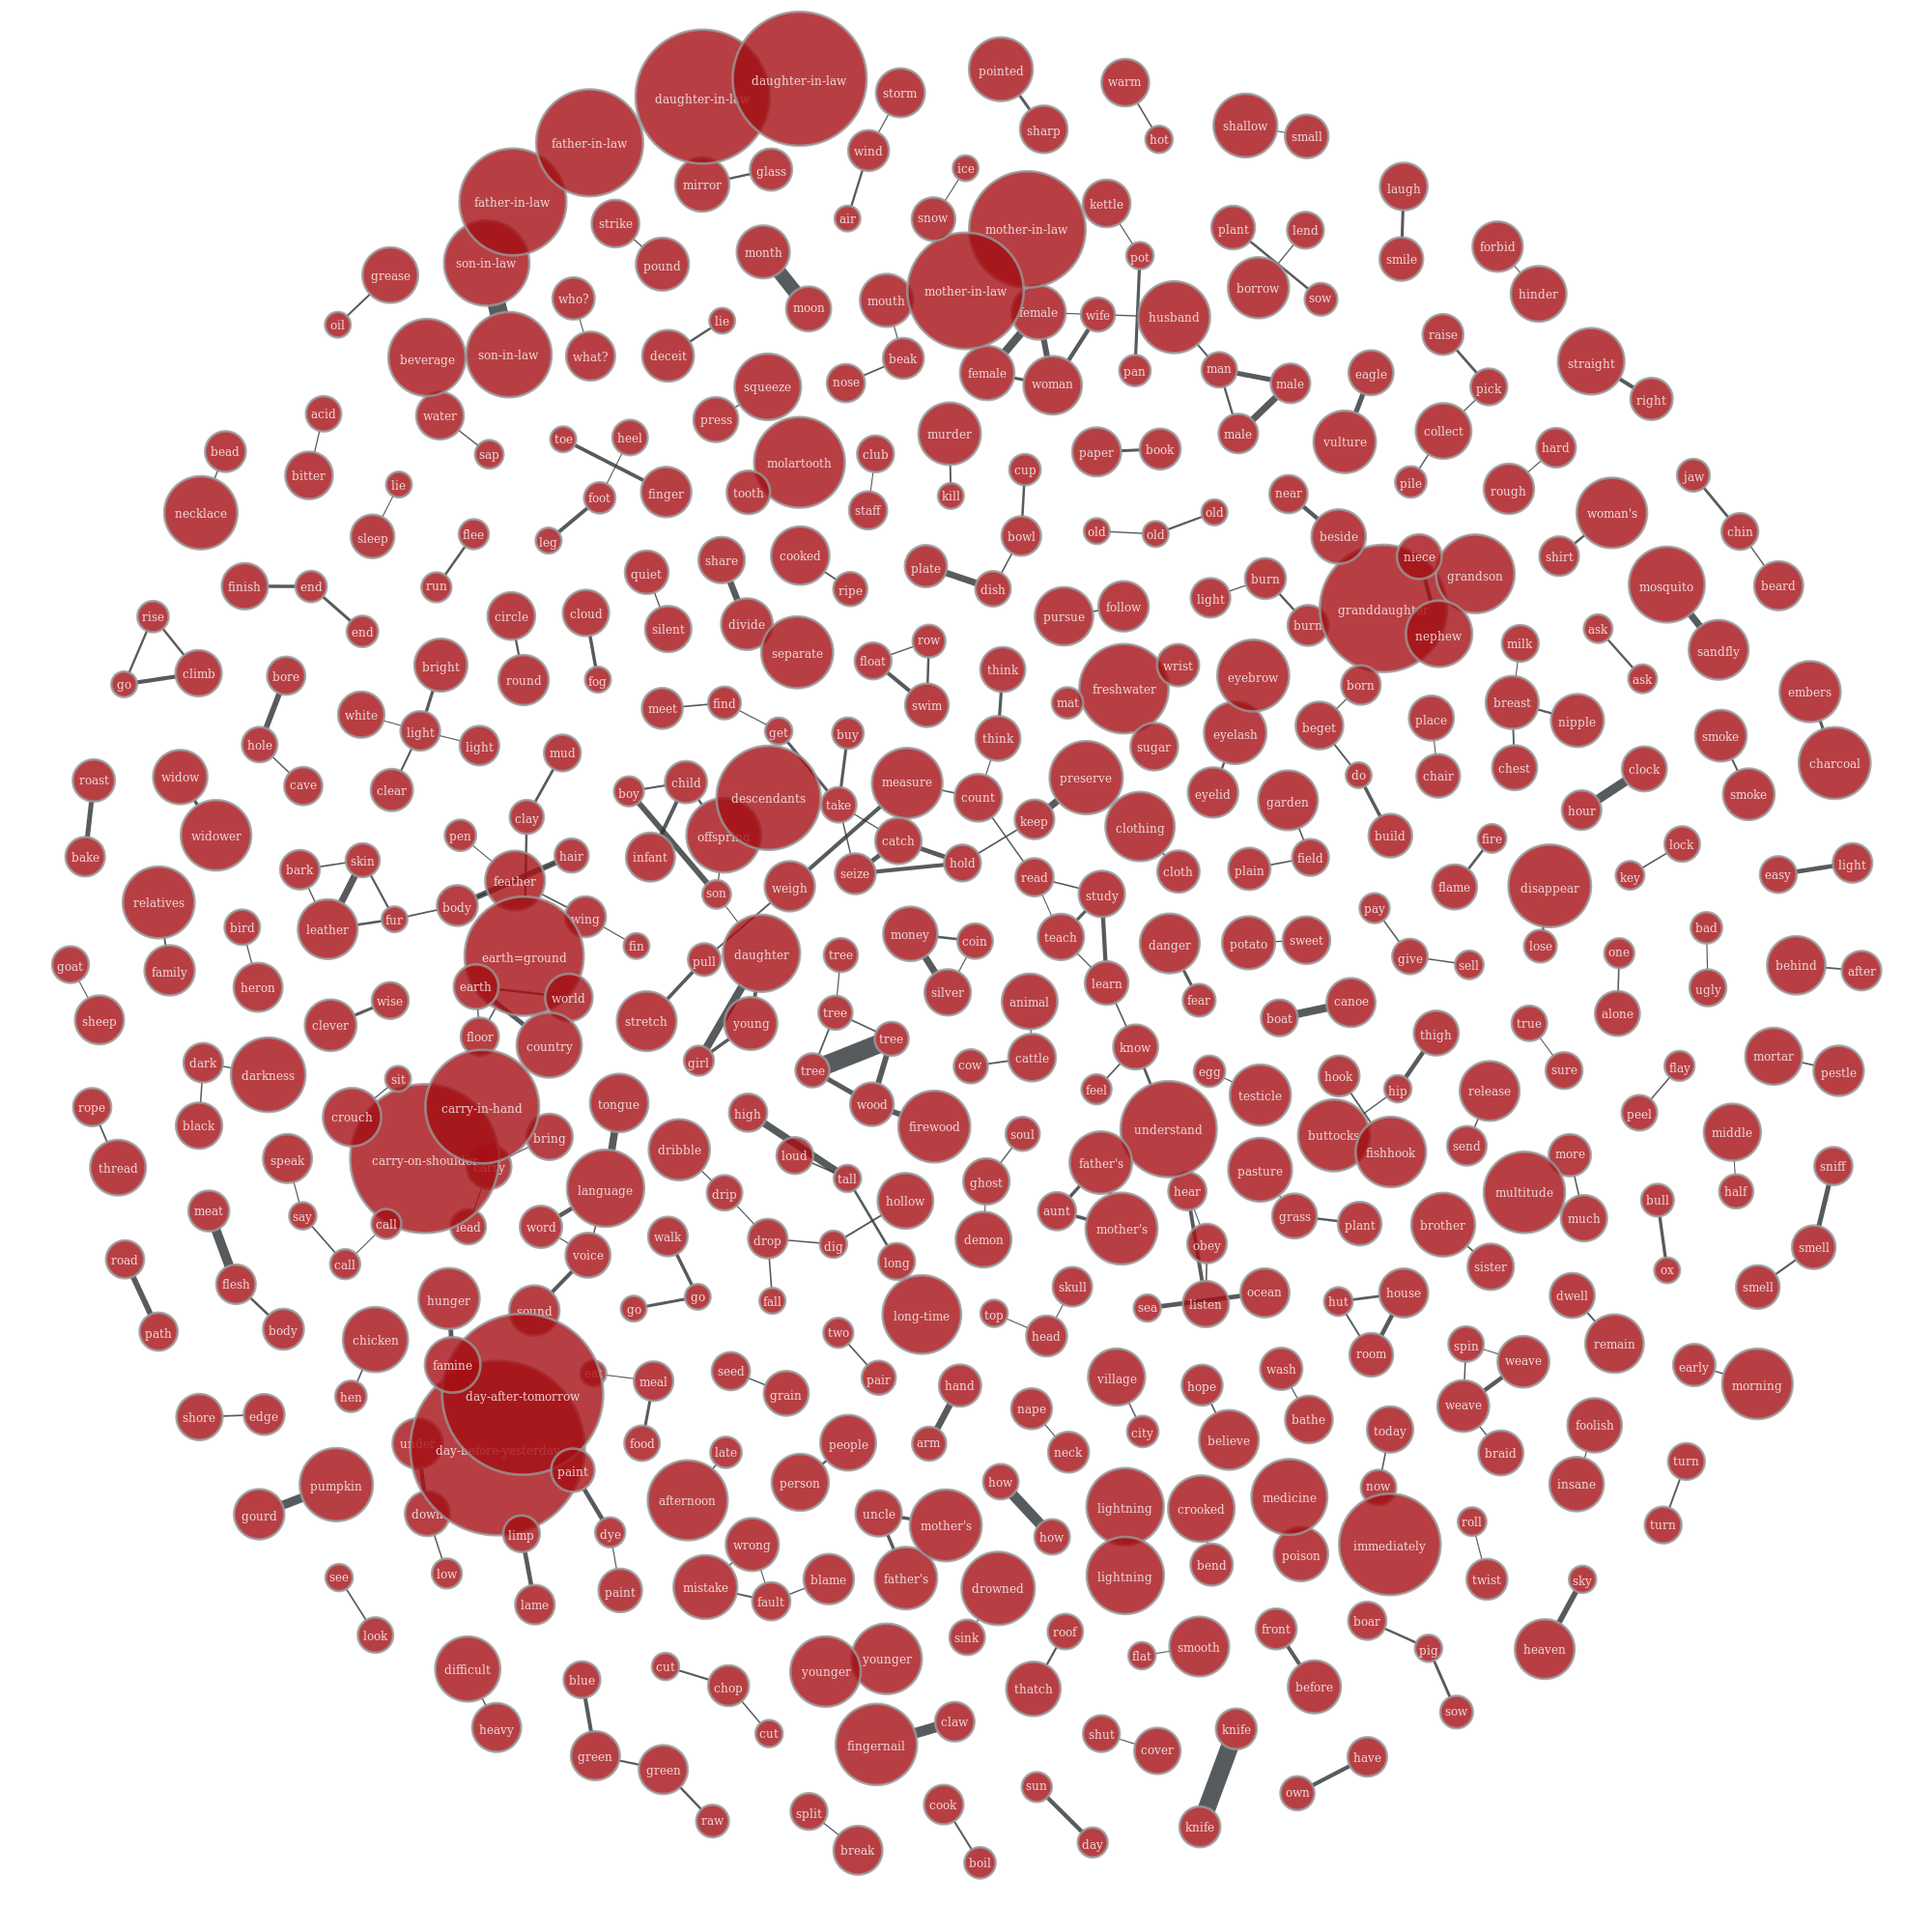

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f372f4b1510, at 0x7f372f4b6f10>

In [130]:
pos = gt.draw.sfdp_layout(g2, eweight=g2.edge_properties['colexDistance'])

graph_draw(g2, pos, output_size=(2000, 2000), vertex_text=g2.vertex_properties["labels"],
           edge_pen_width=g2.edge_properties['numColex'], vcmap=matplotlib.cm.gist_heat_r, output="force/test.png")

In [131]:
def getNumLanguagesWithColex(label1, label2):
    label1_indices = np.argwhere(topThousand['label'].str.contains(label1))
    label2_indices= np.argwhere(topThousand['label'].str.contains(label2))
    
    for lab1_index in label1_indices:
        for lab2_index in label2_indices:
            print(linkM[lab1_index,lab2_index])
    

In [133]:
#getNumLanguagesWithColex('mortar','son-in-law')
#getNumLanguagesWithColex('boat','canoe') # 83
getNumLanguagesWithColex('cook','boil')


[20]
[1]
[0]
[0]
[0]
[0]


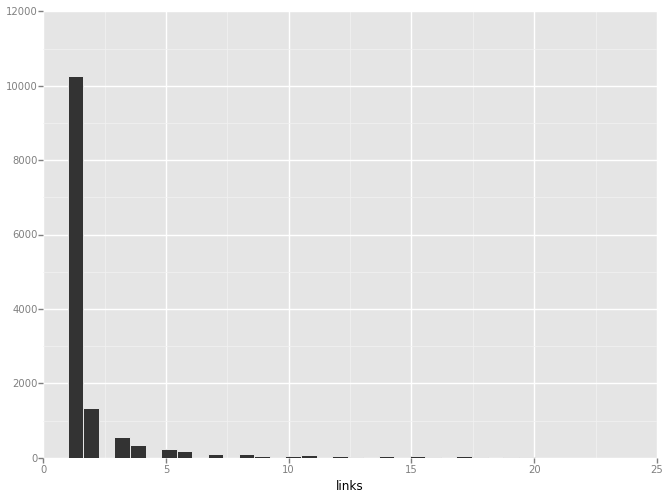

<ggplot: (8742238658945)>

In [134]:
from ggplot import *
nonzeroM = np.asarray(linkM[linkM > 0]).reshape(-1)
numLinks = pandas.DataFrame({'links':nonzeroM}, index=range(len(nonzeroM)))
ggplot(numLinks[numLinks['links'] <= 20], aes(x='links')) + geom_histogram()

In [135]:
float(numLinks['links'].value_counts().iloc[0]) / float(np.sum(numLinks['links'].value_counts()))

0.7398327083934237

73% of colexifications are seen in only a single language. Not so universal, huh?

Todo: <br/>
--make a method for getting the local network for a target concept, with colexifications per language

In [ ]:
Which colexifications correlate with temperature? Proximity to a coast? Average humidity at a location? Altitude? Spectral features? 

Numbers are indicative of the domain— can use this information
Filter to just cross-domain connections, but take a lower filter
Color the nodes with the 

# Extension

For each WIND-neighbor n, is the use of a single form for n and WIND also positively associated with temperature (although perhaps less strongly than for AIR/WIND)?  We are asking this question in order to find out whether the association of AIR/WIND with temperature reflects something more general about the concept WIND, or whether it is specific to AIR/WIND. 

In [ ]:
#items of interest
air (IDS code 1-710)  
storm (IDS code 1-580)
breathe, breath (IDS code 4-510)
weather (IDS code 1-780)

In [149]:
wind_neighbors = getNeighborsForConcept('1-720') #the numbers that are returned here are not glottocodes!
wind_neighbors

{u'1-100': ['yuwa1244'],
 u'1-210': ['yuwa1244'],
 u'1-510': ['rotu1241', 'yuwa1244'],
 u'1-580': ['avar1256',
  'yano1262',
  'lezg1247',
  'arch1244',
  'akhv1239',
  'lakk1252',
  'lakk1252',
  'avar1256',
  'dido1241',
  'avar1256',
  'waiw1244',
  'nina1238'],
 u'1-710': ['arch1244',
  'esee1248',
  'agua1253',
  'polc1243',
  'rotu1241',
  'puin1248',
  'chac1249',
  'pila1245',
  'zaca1242',
  'sion1247',
  'toba1269',
  'east2555',
  'yami1256',
  'pume1238',
  'high1278',
  'wapi1253',
  'seri1257',
  'waiw1244',
  'mula1253',
  'yuwa1244',
  'yavi1244',
  'paez1247',
  'moco1246'],
 u'1-780': ['arch1244', 'rotu1241'],
 u'10-710': ['kumy1244'],
 u'12-340': ['yama1264'],
 u'12-470': ['yama1264'],
 u'14-740': ['komi1268'],
 u'17-230': ['sout2741'],
 u'17-320': ['guib1244', 'zuoj1238'],
 u'22-350': ['chac1251'],
 u'3-160': ['esee1248'],
 u'4-510': ['pila1245', 'toba1269'],
 u'9-790': ['avar1256', 'zaca1242'],
 u'9-791': ['igna1246']}

In [169]:
nearTerms = ['1-710','1-580','4-510','1-780']

results = []
for nearTerm in nearTerms:
    languagesWithColex = getNeighborsForConcept('1-720')[nearTerm]
    temps = [temp_for_glottocode[x] for x in languagesWithColex]
    results.append(pandas.DataFrame({'term':nearTerm, 'temp':temps,'gc':languagesWithColex}))

In [171]:
resultsDF = pandas.concat(results)
print(resultsDF['term'].value_counts())
results

1-710    23
1-580    12
4-510     2
1-780     2
Name: term, dtype: int64


[          gc       temp   term
 0   arch1244   0.433333  1-710
 1   esee1248  26.208333  1-710
 2   agua1253  21.458333  1-710
 3   polc1243  25.250000  1-710
 4   rotu1241  27.016667  1-710
 5   puin1248  26.725000  1-710
 6   chac1249  25.075000  1-710
 7   pila1245  22.666667  1-710
 8   zaca1242  19.458333  1-710
 9   sion1247  25.783333  1-710
 10  toba1269  23.383333  1-710
 11  east2555  23.625000  1-710
 12  yami1256  25.541667  1-710
 13  pume1238  27.616667  1-710
 14  high1278  21.875000  1-710
 15  wapi1253  26.283333  1-710
 16  seri1257  22.591667  1-710
 17  waiw1244  25.941667  1-710
 18  mula1253  19.550000  1-710
 19  yuwa1244  20.225000  1-710
 20  yavi1244  25.233333  1-710
 21  paez1247  13.266667  1-710
 22  moco1246  20.575000  1-710,           gc       temp   term
 0   avar1256   2.716667  1-580
 1   yano1262  25.391667  1-580
 2   lezg1247   3.641667  1-580
 3   arch1244   0.433333  1-580
 4   akhv1239  -0.558333  1-580
 5   lakk1252   4.308333  1-580
 6   lak

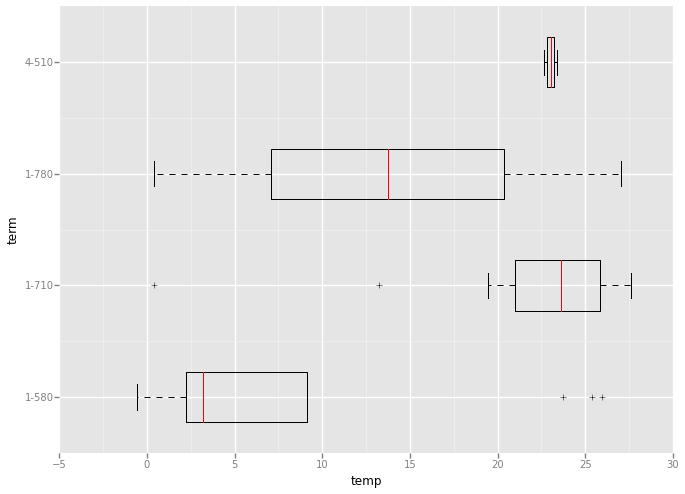

<ggplot: (8742187755649)>

In [176]:
ggplot(resultsDF, aes(y='term', x='temp')) + geom_boxplot()
#throw better labels on here
#why are we missing 3 of the 4-510